# MaxCut

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from hydra import initialize, compose
import dill
import os
import logging
import time
import matplotlib.pyplot as plt
plt.style.use('default')

import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
from qiskit.primitives import BackendSampler
from qiskit_aer import AerProvider

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.bitflip_strategy.Local_Search_QUBO import local_search
from src.optimizer.Quantum_Optimizer_FGSR_b_hardware import QuantumOptimizer
from src.optimizer.utils_logger import make_logger, initialize_data
from src.optimizer.hardware_utils import create_ansatz, get_initial_layout
from maxcut_utils import create_model, create_random_graph

import warnings
warnings.simplefilter('ignore')

In [2]:
# Load config file
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name='config_sample.yaml')

In [3]:
# Set backend
env = cfg.backend.env
qiskit_version = int(qiskit.__version__.split(".")[0])

if cfg.backend.env == "hardware" or cfg.layout.use_real_backend:
    service = QiskitRuntimeService(**cfg.QiskitRuntimeService)

if cfg.layout.use_real_backend:
    layout_backend = service.get_backend(cfg.layout.name)
else:
    layout_backend = None

if cfg.backend.env == "hardware":
    backend = service.get_backend(cfg.backend.name)
    layout_backend = backend
else:
    backend = AerProvider().get_backend(cfg.backend.name)
    service = None

In [4]:
backend

AerSimulator('aer_simulator_matrix_product_state')

In [5]:
layout_backend

<IBMBackend('ibm_torino')>

In [6]:
# Initialize data and logger
output_dir, idx_set, theta, x_ini, fval, indval, df_job_id, df_result = initialize_data(cfg)
logger = make_logger(cfg, output_dir, backend, env)

Parameters:
	instance:
		num_nodes = 120
		degree = 3
		weight_type = one
		random_seed_list = [1]
		trial_list = [0]
		with_labels = True
	optimizer:
		shots = 10000
		search = True
		n_flips = 50
		n_reps = 2
		alpha = 0.4
		random_update = True
		max_epoch = 1
		restart_s = 0.8
		restart_std = 0.0
		early_stop = False
		mixing_ratio = 0
		refval = None
		intermediate_result_display = True
		save_quasi_dist = False
	options:
		save_result = True
		output_dir = results
		timezone = Asia/Tokyo
		verbose = True
		verbose_optimization = False
		restart = False
		date = None
	backend:
		env = simulator
		name = aer_simulator_matrix_product_state
	layout:
		use_real_backend = True
		name = ibm_torino
		automatic_selection = True
		start_qubit = 14
	QiskitRuntimeService:
		channel = ibm_quantum
		instance = client-enablement/its/its-skill-buildi
	runtime:
		resilience_level = 0
		optimization_level = 0
		skip_transpilation = True
	transpile:
		optimization_level = 3


output_dir: results/20240817-202402


In [7]:
idx_set

[]

Backend Info:
	backend = aer_simulator_matrix_product_state
	layout_backend = <IBMBackend('ibm_torino')>
Problem Info:
	num_nodes = 120
	degree = 3
	weight_type = one
----------------------------------------------------------------------------------------------------------------------------------
random_seed = 1 	 num_qubits = 120 	 refval = -163.0
----------------------------------------------------------------------------------------------------------------------------------


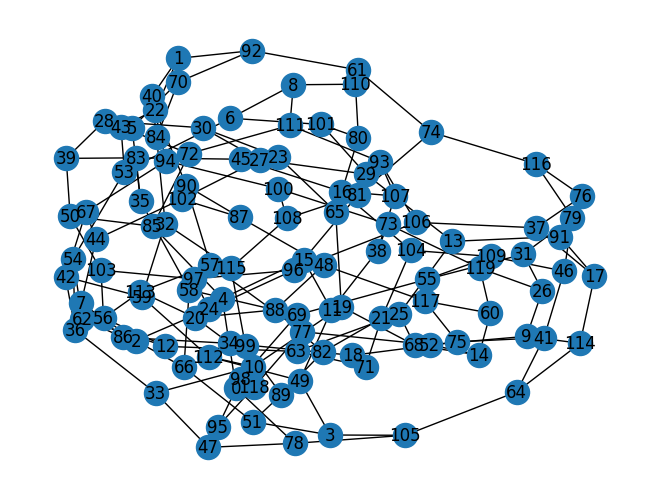

	epoch = 0 	 step = 0 	 (j, k) = (0, 109) 	 objval = -158.000 	 cvar = -96.492   	 s-prob = 0.000e+00
	epoch = 0 	 step = 1 	 (j, k) = (0, 35) 	 objval = -162.000 	 cvar = -149.867   	 s-prob = 0.000e+00
	epoch = 0 	 step = 2 	 (j, k) = (0, 135) 	 objval = -162.000 	 cvar = -153.980   	 s-prob = 0.000e+00
	epoch = 0 	 step = 3 	 (j, k) = (1, 124) 	 objval = -162.000 	 cvar = -153.979   	 s-prob = 0.000e+00
	epoch = 0 	 step = 4 	 (j, k) = (2, 206) 	 objval = -162.000 	 cvar = -154.160   	 s-prob = 0.000e+00
	epoch = 0 	 step = 5 	 (j, k) = (3, 0) 	 objval = -162.000 	 cvar = -154.160   	 s-prob = 0.000e+00
	epoch = 0 	 step = 6 	 (j, k) = (4, 48) 	 objval = -162.000 	 cvar = -154.158   	 s-prob = 0.000e+00
	epoch = 0 	 step = 7 	 (j, k) = (5, 157) 	 objval = -162.000 	 cvar = -154.300   	 s-prob = 0.000e+00
	epoch = 0 	 step = 8 	 (j, k) = (6, 150) 	 objval = -162.000 	 cvar = -154.299   	 s-prob = 0.000e+00
	epoch = 0 	 step = 9 	 (j, k) = (7, 201) 	 objval = -162.000 	 cvar = -154.48

trial = 0 	 step = 242 	 objval = 53 	 cvar = -162.0 	 s-prob = -162.0


In [8]:
# Run optimization
logger.info("Backend Info:")
logger.info(f"\tbackend = {backend}")
logger.info(f"\tlayout_backend = {layout_backend}")
num_nodes = cfg.instance.num_nodes
degree = cfg.instance.degree
weight_type = cfg.instance.weight_type
logger.info("Problem Info:")
logger.info(f"\tnum_nodes = {num_nodes}")
logger.info(f"\tdegree = {degree}")
logger.info(f"\tweight_type = {weight_type}")

shots = cfg.optimizer.shots

result_data = []
for random_seed in cfg.instance.random_seed_list:
    np.random.seed(random_seed)

    # Create graph instance
    graph = create_random_graph(
        degree=degree,
        num_nodes=num_nodes,
        random_seed=random_seed,
        weight_type=weight_type
    )
    Q_data, Q, mdl, cplex_result, refval = create_model(graph)
    num_qubits = graph.number_of_nodes()

    # Define objective
    objective = lambda x: x@Q@x
    def search(x):
        x = local_search(x, Q=Q_data, n_flips=cfg.optimizer.n_flips)
        return np.asarray(x, dtype=int)

    logger.info("-"*130)
    logger.info(f"random_seed = {random_seed} \t num_qubits = {num_qubits} \t refval = {refval}")
    logger.info("-"*130)

    for trial in cfg.instance.trial_list:
        np.random.seed(trial)
        if output_dir is not None:
            output_dir_pb_trial = f"{output_dir}/random_seed{random_seed}_trial{trial}"
            if os.path.exists(output_dir_pb_trial) == False:
                os.mkdir(output_dir_pb_trial)
            with open(f"{output_dir_pb_trial}/graph.pickle", 'wb') as f:
                dill.dump(graph, f)
            nx.draw(graph, with_labels=cfg.instance.with_labels)
            plt.savefig(f"{output_dir_pb_trial}/graph.png")
            plt.savefig(f"{output_dir_pb_trial}/graph.svg", transparent=True, bbox_inches='tight', pad_inches=0)
            plt.show()
        logger_pb = logging.getLogger(f"MaxCut Optimization Log: (random_seed, shots, trial) = {(random_seed, shots, trial)}")
        logger_pb.setLevel(logging.DEBUG)
        if cfg.options.verbose_optimization:
            st_handler_pb = logging.StreamHandler()
            st_handler_pb.setLevel(logging.DEBUG)
            logger_pb.addHandler(st_handler_pb)
        if output_dir is not None:
                fl_handler_pb = logging.FileHandler(filename=f"{output_dir_pb_trial}/optimization.log", mode="a")
                fl_handler_pb.setLevel(logging.DEBUG)
                logger_pb.addHandler(fl_handler_pb)
        logger_pb.info(f"random_seed: {random_seed} \t refval = {refval:.3f} \t shots = {shots} \t trial = {trial}")
        
        # Create initial_layout
        chain_nodes = [i for i in range(num_nodes)]
        sep_nodes = []
        sep_nodes_coupling = []
        if layout_backend is not None:
            if cfg.layout.automatic_selection:
                chain_nodes, sep_nodes, sep_nodes_coupling = get_initial_layout(layout_backend, num_qubits, cfg.layout.start_qubit)
                initial_layout = chain_nodes + sep_nodes
            else:
                initial_layout = cfg.initial_layout[cfg.layout.name][:num_qubits]
        else:
            initial_layout = None
        layout_data = {
            "initial_layout": initial_layout,
            "chain_nodes": chain_nodes,
            "sep_nodes": sep_nodes,
            "sep_nodes_coupling": sep_nodes_coupling
        }
        if output_dir is not None:
            with open(f"{output_dir_pb_trial}/layout_data.pickle", 'wb') as f:
                dill.dump(layout_data, f)
        sub_qc = create_ansatz(cfg.optimizer.n_reps, chain_nodes, sep_nodes, sep_nodes_coupling)
        
        with Session(service=service, backend=backend) as session:
            if env == "hardware":
                options = Options()
                options.execution.shots = shots
                #options.optimization_level = cfg.runtime.optimization_level
                options.resilience_level = cfg.runtime.resilience_level
                options.transpilation.skip_transpilation = cfg.runtime.skip_transpilation # True
                if cfg.backend.name not in ["simulator_stabilizer", "simulator_mps", "simulator_extended_stabilizer", "ibmq_qasm_simulator", "simulator_statevector"]:
                    options.transpilation.initial_layout = initial_layout
                sampler = Sampler(session=session, options=options)
            else:
                sampler = BackendSampler(backend=backend)
                sampler.set_options(shots=shots, seed_simulator=trial)
            QuantumSolver = QuantumOptimizer()
            QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler, env, layout_backend, cfg.transpile.optimization_level, initial_layout)
            QuantumSolver.run(
                objective = objective,
                search = search,
                alpha = cfg.optimizer.alpha,
                random_update = cfg.optimizer.random_update,
                max_epoch = cfg.optimizer.max_epoch,
                restart_s = cfg.optimizer.restart_s,
                restart_std = cfg.optimizer.restart_std,
                refval = refval,
                intermediate_result_display = cfg.optimizer.intermediate_result_display,
                early_stop = cfg.optimizer.early_stop,
                x_ini = x_ini,
                output_dir = output_dir_pb_trial,
                logger = logger_pb,
                seed = trial,
                idx_set = idx_set,
                df_job_id = df_job_id,
                df_result = df_result,
                theta = theta,
                mixing_ratio=cfg.optimizer.mixing_ratio,
                fval=fval,
                indval=indval,
                save_quasi_dist=cfg.optimizer.save_quasi_dist
            )
        step = len(QuantumSolver.result_history)
        objval = QuantumSolver.result_history[-1][3]
        expval = QuantumSolver.result_history[-1][4]
        sprob = QuantumSolver.result_history[-1][5]
        result_data.append([random_seed, num_qubits, refval, backend.name, shots, trial, step, objval, expval, sprob])
        time.sleep(5)
        logger.info(f"trial = {trial} \t step = {step} \t objval = {objval} \t cvar = {expval} \t s-prob = {sprob}")
        df = pd.DataFrame(data=result_data, columns=["random_seed", "num_qubits", "refval", "backend", "shots", "trial", "step", "objval", "cvar", "s-prob"])
        df.to_csv(f"{output_dir}/df_result_summary.csv", index=False)